<b>Case Study</b>

About Dataset Brazilian E-Commerce Public Dataset by Olist Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

Join it With the Marketing Funnel by Olist We have also released a Marketing Funnel Dataset. You may join both datasets and see an order from Marketing perspective now!

Instructions on joining are available on this Kernel.

Context This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

Attention An order might have multiple items. Each item might be fulfilled by a distinct seller. All text identifying stores and partners where replaced by the names of Game of Thrones great houses. Example of a product listing on a marketplace Example of a product listing on a marketplace

Data Schema The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it: Data Schema

Classified Dataset We had previously released a classified dataset, but we removed it at Version 6. We intend to release it again as a new dataset with a new data schema. While we don't finish it, you may use the classified dataset available at the Version 5 or previous.

Inspiration Here are some inspiration for possible outcomes from this dataset.

NLP: This dataset offers a supreme environment to parse out the reviews text through its multiple dimensions.

Clustering: Some customers didn't write a review. But why are they happy or mad?

Sales Prediction: With purchase date information you'll be able to predict future sales.

Delivery Performance: You will also be able to work through delivery performance and find ways to optimize delivery times.

Product Quality: Enjoy yourself discovering the products categories that are more prone to customer insatisfaction.

Feature Engineering: Create features from this rich dataset or attach some external public information to it.

Acknowledgements Thanks to Olist for releasing this dataset


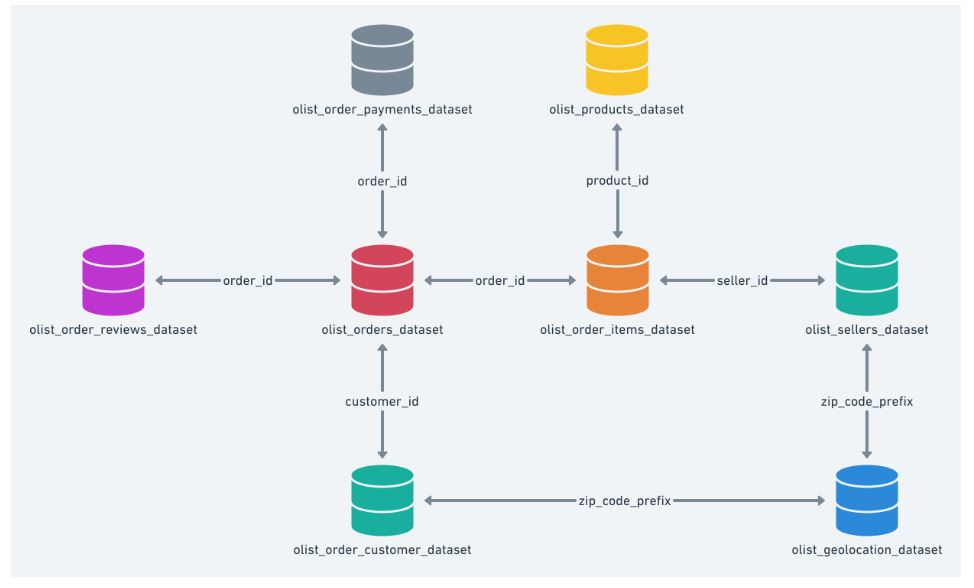

In [3]:
from IPython import display
display.Image("Capture.jpg")

In [19]:
import re
import geopandas as gpd
import json

import pandas as pd
import numpy as np

import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

brazil = gpd.read_file("brazil_geo.json")
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="76.67.117.175")
from geopy.distance import great_circle

In [5]:
geo_orders_df = pd.read_csv('olist_geolocation_dataset.csv')
cust_df = pd.read_csv('olist_customers_dataset.csv')

In [6]:
orders = pd.read_csv('olist_orders_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date']) # datetime conversion
payments = payments.set_index('order_id') # preparation before the join
orders = orders.set_index('order_id') # preparation before the join

joined = orders.join(payments) # join on order_id
joined = joined.reset_index()
joined.head(2)
joined = joined[joined['order_status']=='delivered']

In [7]:
#geo_orders_df = brazil.merge(geo_orders,how="left",left_on="id",right_on="geolocation_state")
geo_orders_df = cust_df.merge(geo_orders_df,how="left",left_on="customer_zip_code_prefix",right_on="geolocation_zip_code_prefix")

In [8]:
joined.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [9]:
geo_orders_df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_zip_code_prefix',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'geolocation_state'],
      dtype='object')

In [10]:
final_df = joined.merge(geo_orders_df,how="left",left_on="customer_id",right_on="customer_id")

In [11]:
final_df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1.0,credit_card,...,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,28013.0,-21.758076,-41.312633,campos dos goytacazes,RJ
1,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1.0,credit_card,...,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,28013.0,-21.758843,-41.306754,campos dos goytacazes,RJ


In [12]:
final_df.shape

(15306898, 21)

### GIS Visualization

In [14]:
last_date = final_df['order_delivered_carrier_date'].max() + pd.to_timedelta(1, 'D')

RFM = final_df.dropna(subset=['order_delivered_carrier_date'])\
            .reset_index()\
            .groupby('geolocation_state')\
            .agg(Recency = ('order_delivered_carrier_date', lambda x: (last_date - x.max()).days ),
                 Frequency = ('order_id', 'size'),
                 Monetary = ('payment_value', 'sum'),
                 Cutomer_count = ('customer_id','nunique'))

In [15]:
RFM.head()

,Recency,Frequency,Monetary,Cutomer_count
geolocation_state,,,,
AC,20,7935,1.806118e+06,119
AL,21,35056,8.345184e+06,396
AM,27,5636,1.037526e+06,145
AP,27,4903,1.172483e+06,67
BA,19,378595,7.127162e+07,3248


In [16]:
AG24_map = folium.Map(location=[14.2350, 51.9253], zoom_start=7, parse_html=True, tiles="cartodbpositron")

In [25]:
AG24_map = folium.Map(location=[-25.388783, -49.205170], zoom_start=13, parse_html=True, tiles="openstreetmap")
df = geo_orders_df[geo_orders_df['customer_city']=="curitiba"]
# Add points to the map
for idx, row in df.iterrows():
    Marker([row['geolocation_lat'], row['geolocation_lng']]).add_to(AG24_map)
    
AG24_map.save("curitiba.html")

<b>MarkerCluster</b>

In [26]:
m_3 = folium.Map(location=[-25.388783, -49.205170], tiles='openstreetmap', zoom_start=13)

# Add points to the map
mc = MarkerCluster()
for idx, row in df.iterrows():
    if not math.isnan(row['geolocation_lat']) and not math.isnan(row['geolocation_lng']):
        mc.add_child(Marker([row['geolocation_lat'], row['geolocation_lng']]))
m_3.add_child(mc)

# Display the map
m_3.save("curitiba_cluster.html")

#### Bubble maps

In [27]:
m_4 = folium.Map(location=[-25.388783, -49.205170], tiles='openstreetmap', zoom_start=13)

def color_producer(val):
    if val <= 12:
        return 'forestgreen'
    else:
        return 'darkred'

# Add a bubble map to the base map
for i in range(0,len(df)):
    Circle(
        location=[df.iloc[i]['geolocation_lat'], df.iloc[i]['geolocation_lng']],
        radius=20,
        color='darkred').add_to(m_4)

# Display the map
m_4.save("curitiba_bubble.html")

<b>Heatmaps</b>

In [28]:
m_4 = folium.Map(location=[-25.388783, -49.205170], tiles='openstreetmap', zoom_start=13)


# Add a heatmap to the base map
HeatMap(data=df[['geolocation_lat', 'geolocation_lng']], radius=10).add_to(m_4)

# Display the map
m_4.save("curitiba_heatmap.html")

<b>Choropleth maps</b>

In [51]:
brazil = brazil[['id','geometry']].drop_duplicates()
brazil = brazil.set_index('id')
brazil.head(2)

,geometry
id,
AC,"POLYGON ((-73.33251 -7.32488, -73.27482 -7.350..."
AL,"MULTIPOLYGON (((-35.90153 -9.86181, -35.90153 ..."


In [64]:
Customer_df = RFM[['Cutomer_count']]
Customer_df.rename(index={'geolocation_state': 'id'}, inplace=True)

In [66]:
m_6 = folium.Map(location=[-25.388783, -49.205170], tiles='openstreetmap', zoom_start=13)

Choropleth(geo_data=brazil.__geo_interface__, 
           data=Customer_df, 
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='States by customer'
          ).add_to(m_6)

# Display the map
m_6.save("Choropleth.html")

TypeError: 'NoneType' object is not subscriptable

<b>Geo Coding</b>

In [67]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="kaggle_learn")
location = geolocator.geocode("135 east liberty street toronto")

print(location.point)
print(location.address)

point = location.point
print("Latitude:", point.latitude)
print("Longitude:", point.longitude)

43 38m 18.3764s N, 79 24m 58.9738s W
135, East Liberty Street, Little Tibet, Spadina—Fort York, Old Toronto, Toronto, Golden Horseshoe, Ontario, M6K 3P8, Canada
Latitude: 43.63843789411379
Longitude: -79.41638161533305


In [68]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="kaggle_learn")
location = geolocator.geocode("65 Bremner Blvd toronto")

print(location.point)
print(location.address)

point = location.point
print("Latitude:", point.latitude)
print("Longitude:", point.longitude)

43 38m 34.0591s N, 79 22m 50.1061s W
Maple Leaf Square North, 65, Bremner Boulevard, Spadina—Fort York, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5J 0A7, Canada
Latitude: 43.6427942
Longitude: -79.38058501407745


<b>Calculate distance</b>

In [69]:
def Vincenty_calc(lat1,lon1,lat2,lon2):
    try:
        newport_ri = (lat1, lon1)
        cleveland_oh = (lat2, lon2)
        #print(great_circle(newport_ri, cleveland_oh).meters)
        a = great_circle(newport_ri, cleveland_oh).meters
        return (a/1000)
    except:
        #print('expect')
        return None

In [70]:
print(Vincenty_calc(43.63843789411379,-79.41638161533305,43.63843789411379,-79.41638161533305))

None
